In [1]:
# ---------------------------------------- File 6_MIWM_roads_2021 ---------------------------------------- #
# This is file is the sixth step in creating the NSMI which gathers, analyses, and merges spatial data 
# This script will locate the shapefiles containing information of roads in the Netherlands from the Dutch Ministry of Infrastructure and Water Management as it was at the end of 2021.

# Importing necessary libraries for this script
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import multiprocessing as mp
from shapely.geometry import box
import contextily as ctx

In [2]:
# ---------------------------------------- Part 1 ---------------------------------------- #
# This part locates the shapefile containing the road geometries and the maximum speed information for 2021 from the Dutch Ministry of Infrastructure and Water Management.
# After locating and analysing the files, the files can be merged and the redundant columns can be removed. 
# This part allows furher analysis on the road lengths per neighborhood that will be done in step 2. 

In [3]:
# This line sets the path to the shapefile
shapefile_source_2021 = r'C:\Users\20182306\OneDrive - TU Eindhoven\Documents\Master - Jaar 1, 2 & 3\year 3\INPUT\roads\01-11-2021\01-11-2021\Speed\Wegvakdeel N\Wegvakken.shp'

# This line uses geopandas to read the shapefile and load it into a GeoDataFrame
roads_2021_original = gpd.read_file(shapefile_source_2021)

In [4]:
# Set the option to display all columns
pd.set_option('display.max_columns', None)

display(roads_2021_original.head(5))

,WVK_ID,WVK_BEGDAT,NWB_VERSIE,PVE_CODE,GME_ID,GME_NAAM,STT_NAAM,WEGNUMMER,WEGBEHSRT,WEGBEHCODE,WEGBEHNAAM,FK_VELD1,geometry
0,47194001,1997-08-29,2021-11-01,ZL,717,Veere,Schamsweg,None,G,717,Veere,004719400119970829,"LINESTRING (23958.000 397503.000, 23994.000 39..."
1,47194002,1997-08-29,2021-11-01,ZL,717,Veere,Schamsweg,None,G,717,Veere,004719400219970829,"LINESTRING (23919.000 397500.000, 23958.000 39..."
2,46184029,1998-02-14,2021-11-01,ZL,717,Veere,Swaalingestraat,None,G,717,Veere,004618402919980214,"LINESTRING (23199.000 392248.000, 23213.000 39..."
3,46184030,1998-02-14,2021-11-01,ZL,717,Veere,Swaalingestraat,None,G,717,Veere,004618403019980214,"LINESTRING (23207.000 392265.000, 23213.000 39..."
4,95137012,1998-02-12,2021-11-01,ZL,715,Terneuzen,Mr. F.J. Haarmanweg,None,G,715,Terneuzen,009513701219980212,"LINESTRING (47747.000 368926.000, 47760.000 36..."


In [5]:
# Get the number of rows and columns
num_rows, num_cols = roads_2021_original.shape
print(f"The dataset has {num_rows} rows and {num_cols} columns.")

# Get descriptive statistics
stats = roads_2021_original.describe()
print(stats)

The dataset has 1111761 rows and 13 columns.
             WVK_ID        GME_ID
count  1.111761e+06  1.111761e+06
mean   3.490733e+08  8.031111e+02
std    1.430456e+08  6.313241e+02
min    2.714201e+07  1.400000e+01
25%    2.323751e+08  3.070000e+02
50%    3.381360e+08  5.990000e+02
75%    4.442760e+08  9.950000e+02
max    6.004727e+08  1.979000e+03


In [6]:
# This line sets the path to the excel file containing the maximum speed information
max_speed_source_2021 = r'C:\Users\20182306\OneDrive - TU Eindhoven\Documents\Master - Jaar 1, 2 & 3\year 3\INPUT\roads\01-11-2021\01-11-2021\Speed\Wegvakdeel N\MAX_SNELHEDEN.CSV'

# This line uses geopandas to read the shapefile and load it into a GeoDataFrame
max_speed_2021_original = pd.read_csv(max_speed_source_2021, sep='\s+')

In [7]:
# Set the option to display all columns
pd.set_option('display.max_columns', None)

display(max_speed_2021_original.head(5))

,WVK_ID,WVK_BEGDAT,NWB_VERSIE,HDE_SHT,D_HDE_SHT,FK_VELD1
0,47194001,29-08-1997,01-11-2021,KMH_60,13-10-2016,4719400119970829
1,47194002,29-08-1997,01-11-2021,KMH_60,13-10-2016,4719400219970829
2,46184029,14-02-1998,01-11-2021,KMH_30,13-10-2016,4618402919980214
3,46184030,14-02-1998,01-11-2021,KMH_30,13-10-2016,4618403019980214
4,95137012,12-02-1998,01-11-2021,KMH_80,13-10-2016,9513701219980212


In [8]:
# Get the number of rows and columns
num_rows, num_cols = max_speed_2021_original.shape
print(f"The dataset has {num_rows} rows and {num_cols} columns.")

# Get descriptive statistics
stats = max_speed_2021_original.describe()
print(stats)

# Get descriptive statistics of the max speed column
stats = max_speed_2021_original['HDE_SHT'].describe()
print(stats)

# Get the number of NaN values in the HDE_SHT column
num_nan = max_speed_2021_original['HDE_SHT'].isna().sum()
print(f"The HDE_SHT column has {num_nan} NaN values.")

The dataset has 1111761 rows and 6 columns.
             WVK_ID      FK_VELD1
count  1.111761e+06  1.111761e+06
mean   3.490733e+08  3.490733e+16
std    1.430456e+08  1.430456e+16
min    2.714201e+07  2.714201e+15
25%    2.323751e+08  2.323751e+16
50%    3.381360e+08  3.381360e+16
75%    4.442760e+08  4.442760e+16
max    6.004727e+08  6.004727e+16
count     1111761
unique         14
top        KMH_30
freq       606275
Name: HDE_SHT, dtype: object
The HDE_SHT column has 0 NaN values.


In [9]:
# Merge the GeoDataFrame containing the road geodata with the DataFrame containing the speed information
roads_with_speed_2021 = roads_2021_original.merge(max_speed_2021_original, on='WVK_ID', how='left')

# Get the number of NaN values in the HDE_SHT column
num_nan = roads_with_speed_2021['HDE_SHT'].isna().sum()
print(f"The HDE_SHT column has {num_nan} NaN values.")
num_rows, num_cols = roads_with_speed_2021.shape
print(f"The dataset has {num_rows} rows and {num_cols} columns.")

The HDE_SHT column has 0 NaN values.
The dataset has 1111761 rows and 18 columns.


In [10]:
# Make a copy of the dataframe with only the specified columns
roads_with_speed_2021_cleaned = roads_with_speed_2021[['WVK_ID', 'geometry', 'HDE_SHT']].copy()

# Rename the columns
roads_with_speed_2021_cleaned = roads_with_speed_2021_cleaned.rename(columns={'WVK_ID': 'ROAD_ID', 'HDE_SHT': 'MAX_SPEED'})

display(roads_with_speed_2021_cleaned.head(10))

# Get the number of NaN values in the dataset
num_nan_MAXSPEED = roads_with_speed_2021_cleaned['MAX_SPEED'].isna().sum()
print(f"The MAX_SPEED column has {num_nan_MAXSPEED} NaN values.")

num_nan_geometry = roads_with_speed_2021_cleaned['geometry'].isna().sum()
print(f"The geometry column has {num_nan_geometry} NaN values.")

num_nan_ROADID = roads_with_speed_2021_cleaned['ROAD_ID'].isna().sum()
print(f"The HDE_SHT column has {num_nan_ROADID} NaN values.")

num_rows, num_cols = roads_with_speed_2021_cleaned.shape
print(f"The dataset has {num_rows} rows and {num_cols} columns.")

# Show how many unique values the column MAX_SPEED has.
num_unique_values = roads_with_speed_2021_cleaned['MAX_SPEED'].nunique()
print(f"The MAX_SPEED column has {num_unique_values} unique values.")

# Get the unique values in the MAX_SPEED column
unique_values = roads_with_speed_2021_cleaned['MAX_SPEED'].unique()
print(f"The unique values in the MAX_SPEED column are: {unique_values}")

,ROAD_ID,geometry,MAX_SPEED
0,47194001,"LINESTRING (23958.000 397503.000, 23994.000 39...",KMH_60
1,47194002,"LINESTRING (23919.000 397500.000, 23958.000 39...",KMH_60
2,46184029,"LINESTRING (23199.000 392248.000, 23213.000 39...",KMH_30
3,46184030,"LINESTRING (23207.000 392265.000, 23213.000 39...",KMH_30
4,95137012,"LINESTRING (47747.000 368926.000, 47760.000 36...",KMH_80
5,95140025,"LINESTRING (47660.000 370223.000, 47657.000 37...",KMH_30
6,95142059,"LINESTRING (47575.000 371162.000, 47582.000 37...",KMH_30
7,95142067,"LINESTRING (47664.000 371188.000, 47722.000 37...",KMH_30
8,95142087,"LINESTRING (47782.000 371266.000, 47789.000 37...",KMH_30
9,95142090,"LINESTRING (47827.000 371157.000, 47834.000 37...",KMH_30


The MAX_SPEED column has 0 NaN values.
The geometry column has 0 NaN values.
The HDE_SHT column has 0 NaN values.
The dataset has 1111761 rows and 3 columns.
The MAX_SPEED column has 14 unique values.
The unique values in the MAX_SPEED column are: ['KMH_60' 'KMH_30' 'KMH_80' 'KMH_50' 'KMH_70' 'HST_NOA' 'KMH_12' 'KMH_100'
 'KMH_120' 'KMH_15' 'KMH_130' 'KMH_90' 'HST_NVT' 'HST_ADS']


In [11]:
# Save the GeoDataFrame as a .gpkg file
roads_with_speed_2021_cleaned.to_file("C:/Users/20182306/OneDrive - TU Eindhoven/Documents/We-Boost/Repositories/Mobility-Index/intermediate/roads_with_max_speed_2021.gpkg", driver="GPKG")

In [12]:
# ---------------------------------------- Part 2 ---------------------------------------- #
# This part locates the geopackage file 5_2_1 which contains the socio-demographic data, proximity data, greenery data, water, and build-up area data for every neighborhood in 2021.
# After locating this file, the geopackage with the geodata of roads with the corresponding maximum speed will be used to obtain the road lengths per maxmimum speeds classification per neighborhood. 

In [13]:
# This line sets the path to the shapefile
geopackage_input_2021_location = r'C:\Users\20182306\OneDrive - TU Eindhoven\Documents\We-Boost\Repositories\Mobility-Index\output\5_2_2_OSM_buildings_2021.gpkg'

# This line uses geopandas to read the geopackage with the neighborhood data and loads it into a GeoDataFrame
geopackage_input_2021 = gpd.read_file(geopackage_input_2021_location)

# Display the first 5 rows of the GeoDataFrame which is the input of the neighborhood data.
display(geopackage_input_2021.head(5))

,neighborhoodcode,neighborhoodname,populationdensityperkm2,percentage0to15years,percentage15to25years,percentage25to45years,percentage45to65years,percentage65yearsorolder,percentageonepersonhouseholds,percentagehouseholdswithoutchildren,percentagehouseholdswithchildren,percentagewesternmigrationbackground,percentagenonwesternmigrationbackground,percentagemen,Distancetolargesupermarket,Distancetodailylifeprovisions,DistanceToPrimaryEducation,DistanceToSecundaryEducation,area_greenery,area_water,area_buildings,geometry
0,BU00140000,Binnenstad-Noord,12192.0,2.0,47.0,35.0,11.0,6.0,82.0,16.0,3.0,19.0,10.0,52.8,0.3,0.1,0.3,0.7,6624.409779,19841.853490,159146.424148,"MULTIPOLYGON (((233836.216 582380.178, 233892...."
1,BU00140001,Binnenstad-Zuid,11651.0,2.0,46.0,34.0,11.0,7.0,81.0,16.0,3.0,18.0,12.0,53.1,0.2,0.1,0.7,0.9,22284.753602,38974.572262,242741.490433,"MULTIPOLYGON (((233933.980 581951.340, 233973...."
2,BU00140002,Binnenstad-Oost,15441.0,3.0,42.0,35.0,11.0,9.0,79.0,17.0,4.0,18.0,14.0,52.5,0.5,0.2,0.7,0.4,8335.684283,23497.237602,102269.319342,"MULTIPOLYGON (((233998.790 582526.540, 234278...."
3,BU00140003,Binnenstad-West,17200.0,2.0,38.0,41.0,10.0,10.0,80.0,17.0,3.0,20.0,10.0,54.7,0.3,0.2,0.9,1.1,0.000000,10530.689805,49307.342094,"MULTIPOLYGON (((233187.240 581984.190, 233217...."
4,BU00140005,Hortusbuurt-Ebbingekwartier,13019.0,5.0,37.0,33.0,15.0,10.0,78.0,16.0,6.0,19.0,11.0,50.1,0.3,0.2,0.6,0.8,20667.446628,15105.460496,152145.885472,"MULTIPOLYGON (((234098.513 582873.654, 233828...."


In [14]:
# Set the CRS for both GeoDataFrames
geopackage_input_2021 = geopackage_input_2021.to_crs('EPSG:28992')
roads_with_speed_2021_cleaned = roads_with_speed_2021_cleaned.to_crs('EPSG:28992')

In [15]:
# Create a bounding box for each neighborhood geometry
geopackage_input_2021['bounding_box'] = geopackage_input_2021['geometry'].apply(lambda x: x.bounds)
display(geopackage_input_2021.head(5))

,neighborhoodcode,neighborhoodname,populationdensityperkm2,percentage0to15years,percentage15to25years,percentage25to45years,percentage45to65years,percentage65yearsorolder,percentageonepersonhouseholds,percentagehouseholdswithoutchildren,percentagehouseholdswithchildren,percentagewesternmigrationbackground,percentagenonwesternmigrationbackground,percentagemen,Distancetolargesupermarket,Distancetodailylifeprovisions,DistanceToPrimaryEducation,DistanceToSecundaryEducation,area_greenery,area_water,area_buildings,geometry,bounding_box
0,BU00140000,Binnenstad-Noord,12192.0,2.0,47.0,35.0,11.0,6.0,82.0,16.0,3.0,19.0,10.0,52.8,0.3,0.1,0.3,0.7,6624.409779,19841.853490,159146.424148,"MULTIPOLYGON (((233836.216 582380.178, 233892....","(233142.23000000045, 581743.5300000012, 234188..."
1,BU00140001,Binnenstad-Zuid,11651.0,2.0,46.0,34.0,11.0,7.0,81.0,16.0,3.0,18.0,12.0,53.1,0.2,0.1,0.7,0.9,22284.753602,38974.572262,242741.490433,"MULTIPOLYGON (((233933.980 581951.340, 233973....","(233257.8200000003, 581232.0399999991, 234451...."
2,BU00140002,Binnenstad-Oost,15441.0,3.0,42.0,35.0,11.0,9.0,79.0,17.0,4.0,18.0,14.0,52.5,0.5,0.2,0.7,0.4,8335.684283,23497.237602,102269.319342,"MULTIPOLYGON (((233998.790 582526.540, 234278....","(233749.03599999845, 581668.870000001, 234685...."
3,BU00140003,Binnenstad-West,17200.0,2.0,38.0,41.0,10.0,10.0,80.0,17.0,3.0,20.0,10.0,54.7,0.3,0.2,0.9,1.1,0.000000,10530.689805,49307.342094,"MULTIPOLYGON (((233187.240 581984.190, 233217....","(233062.55999999866, 581356.1600000001, 233300..."
4,BU00140005,Hortusbuurt-Ebbingekwartier,13019.0,5.0,37.0,33.0,15.0,10.0,78.0,16.0,6.0,19.0,11.0,50.1,0.3,0.2,0.6,0.8,20667.446628,15105.460496,152145.885472,"MULTIPOLYGON (((234098.513 582873.654, 233828....","(233046.56109999865, 582044.1169000007, 234098..."


In [16]:
# Create a dictionary to store the roads DataFrames for each neighborhood
neighborhood_roads = {}

# Iterate over each row in geopackage_input_2021
for idx, neighborhood in geopackage_input_2021.iterrows():
    # Create a box from the bounding box
    bounding_box = box(*neighborhood['bounding_box'])
    
    # Check which roads are completely within the bounding box
    roads_within = roads_with_speed_2021_cleaned[roads_with_speed_2021_cleaned['geometry'].within(bounding_box)]
    
    # Check which roads are partly within the bounding box
    roads_intersect = roads_with_speed_2021_cleaned[roads_with_speed_2021_cleaned['geometry'].intersects(bounding_box)]
    
    # Concatenate the roads that are within or intersect the bounding box
    roads = pd.concat([roads_within, roads_intersect]).drop_duplicates()

    # Convert the neighborhood geometry to a GeoDataFrame and set its CRS
    neighborhood_gdf = gpd.GeoDataFrame(geometry=[neighborhood['geometry']], crs=roads.crs)
    
    # Clip the roads to the neighborhood geometry
    clipped_roads = gpd.overlay(roads, neighborhood_gdf, how='intersection')
    
    # Store the clipped roads DataFrame in the dictionary
    neighborhood_roads[idx] = clipped_roads

C:\Users\20182306\AppData\Local\Temp\ipykernel_21440\2642930365.py:22: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  clipped_roads = gpd.overlay(roads, neighborhood_gdf, how='intersection')
C:\Users\20182306\AppData\Local\Temp\ipykernel_21440\2642930365.py:22: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  clipped_roads = gpd.overlay(roads, neighborhood_gdf, how='intersection')
C:\Users\20182306\AppData\Local\Temp\ipykernel_21440\2642930365.py:22: UserWarning: `keep_geom_type=True` in overlay resulted in 16 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  clipped_roads = gpd.overlay(roads, neighborhood_gdf, how='intersection')
C:\Users\20182306\AppData\Local\Temp\ipyke

In [17]:
# Define the speed categories
speed_categories = ['KMH_60', 'KMH_30', 'KMH_80', 'KMH_50', 'KMH_70', 'HST_NOA', 'KMH_15', 'KMH_12', 'HST_NVT', 'KMH_120', 'KMH_100', 'KMH_130', 'KMH_90']

# Initialize the speed categories columns in geopackage_input_2021 with 0.0 (float)
for category in speed_categories:
    geopackage_input_2021[category] = 0.0

# Iterate over the neighborhood_roads dictionary
for idx, roads in neighborhood_roads.items():
    # Calculate the length of each road
    roads['length'] = roads['geometry'].length
    
    # Group the roads by the MAX_SPEED column and calculate the sum of their lengths
    road_lengths = roads.groupby('MAX_SPEED')['length'].sum()
    
    # Assign the road lengths to the corresponding columns in geopackage_input_2021
    for category in speed_categories:
        if category in road_lengths:
            # Convert the column to float before setting the value
            geopackage_input_2021[category] = geopackage_input_2021[category].astype(float)
            geopackage_input_2021.loc[idx, category] = road_lengths[category]

In [18]:
display(geopackage_input_2021.head(10))

,neighborhoodcode,neighborhoodname,populationdensityperkm2,percentage0to15years,percentage15to25years,percentage25to45years,percentage45to65years,percentage65yearsorolder,percentageonepersonhouseholds,percentagehouseholdswithoutchildren,percentagehouseholdswithchildren,percentagewesternmigrationbackground,percentagenonwesternmigrationbackground,percentagemen,Distancetolargesupermarket,Distancetodailylifeprovisions,DistanceToPrimaryEducation,DistanceToSecundaryEducation,area_greenery,area_water,area_buildings,geometry,bounding_box,KMH_60,KMH_30,KMH_80,KMH_50,KMH_70,HST_NOA,KMH_15,KMH_12,HST_NVT,KMH_120,KMH_100,KMH_130,KMH_90
0,BU00140000,Binnenstad-Noord,12192.0,2.0,47.0,35.0,11.0,6.0,82.0,16.0,3.0,19.0,10.0,52.8,0.3,0.1,0.3,0.7,6624.409779,19841.853490,159146.424148,"MULTIPOLYGON (((233836.216 582380.178, 233892....","(233142.23000000045, 581743.5300000012, 234188...",0.0,9728.001538,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,BU00140001,Binnenstad-Zuid,11651.0,2.0,46.0,34.0,11.0,7.0,81.0,16.0,3.0,18.0,12.0,53.1,0.2,0.1,0.7,0.9,22284.753602,38974.572262,242741.490433,"MULTIPOLYGON (((233933.980 581951.340, 233973....","(233257.8200000003, 581232.0399999991, 234451....",0.0,16299.184957,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,BU00140002,Binnenstad-Oost,15441.0,3.0,42.0,35.0,11.0,9.0,79.0,17.0,4.0,18.0,14.0,52.5,0.5,0.2,0.7,0.4,8335.684283,23497.237602,102269.319342,"MULTIPOLYGON (((233998.790 582526.540, 234278....","(233749.03599999845, 581668.870000001, 234685....",0.0,4746.949424,0.0,2499.953383,0.000000,704.777948,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,BU00140003,Binnenstad-West,17200.0,2.0,38.0,41.0,10.0,10.0,80.0,17.0,3.0,20.0,10.0,54.7,0.3,0.2,0.9,1.1,0.000000,10530.689805,49307.342094,"MULTIPOLYGON (((233187.240 581984.190, 233217....","(233062.55999999866, 581356.1600000001, 233300...",0.0,2271.545869,0.0,521.712521,0.000000,30.530014,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,BU00140005,Hortusbuurt-Ebbingekwartier,13019.0,5.0,37.0,33.0,15.0,10.0,78.0,16.0,6.0,19.0,11.0,50.1,0.3,0.2,0.6,0.8,20667.446628,15105.460496,152145.885472,"MULTIPOLYGON (((234098.513 582873.654, 233828....","(233046.56109999865, 582044.1169000007, 234098...",0.0,6586.123271,0.0,2911.091342,0.000000,0.000000,0.0,761.036413,0.0,0.0,0.0,0.0,0.0
5,BU00140008,Stationsgebied,2438.0,0.0,61.0,10.0,10.0,18.0,87.0,12.0,2.0,44.0,13.0,43.8,0.5,0.1,0.8,1.1,3861.071987,19999.636264,22104.339413,"MULTIPOLYGON (((233337.498 581338.762, 233620....","(233257.8200000003, 581074.1499999985, 234107....",0.0,2527.029546,0.0,2147.424583,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
6,BU00140100,De Meeuwen,6445.0,9.0,28.0,23.0,21.0,18.0,67.0,20.0,13.0,28.0,9.0,49.6,0.8,0.7,0.9,1.4,34015.180916,14528.805501,31393.834480,"MULTIPOLYGON (((234797.961 581673.766, 234848....","(234451.01999999955, 580993.0571000017, 235263...",0.0,1680.495953,0.0,3546.866052,706.850379,639.495153,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
7,BU00140101,Oosterpoort,12473.0,5.0,30.0,36.0,18.0,11.0,70.0,22.0,8.0,16.0,8.0,49.9,0.3,0.3,0.3,1.2,14004.946943,21547.801378,127275.785212,"MULTIPOLYGON (((234489.011 581633.703, 234532....","(234025.75, 580765.4715000018, 234933.31109999...",0.0,9211.901956,0.0,1002.535314,694.900229,109.076905,0.0,392.799616,0.0,0.0,0.0,0.0,0.0
8,BU00140102,Herewegbuurt,9819.0,7.0,32.0,38.0,16.0,7.0,69.0,22.0,9.0,16.0,9.0,47.5,0.6,0.5,0.6,0.7,10415.431333,0.000000,39996.883489,"MULTIPOLYGON (((234250.140 581055.220, 234347....","(234107.5, 580510.5507000014, 234680.068300001...",0.0,2511.656112,0.0,666.066447,903.928658,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
9,BU00140103,Rivierenbuurt,8291.0,4.0,30.0,38.0,14.0,13.0,71.0,22.0,6.0,15.0,9.0,49.1,0.3,0.3,0.3,0.3,63863.572402,17107.658995,102422.439998,"MULTIPOLYGON (((234107.500 581107.000, 234110....","(233307.1000000015, 580233.7864999995, 234307....",0.0,5768.111428,0.0,5463.743893,1132.831175,482.590872,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [19]:
# Rename the columns and merge columns in groups based on their speed category
geopackage_input_2021 = geopackage_input_2021.assign(
    road_length_residential = geopackage_input_2021[['KMH_12', 'KMH_15', 'KMH_30', 'KMH_50']].sum(axis=1),
    road_length_rural = geopackage_input_2021[['KMH_60', 'KMH_70', 'KMH_80']].sum(axis=1),
    road_length_highway = geopackage_input_2021[['KMH_90', 'KMH_100', 'KMH_120', 'KMH_130']].sum(axis=1),
    road_length_active = geopackage_input_2021[['HST_NOA', 'HST_NVT']].sum(axis=1)
)

In [20]:
display(geopackage_input_2021.head(10))

,neighborhoodcode,neighborhoodname,populationdensityperkm2,percentage0to15years,percentage15to25years,percentage25to45years,percentage45to65years,percentage65yearsorolder,percentageonepersonhouseholds,percentagehouseholdswithoutchildren,percentagehouseholdswithchildren,percentagewesternmigrationbackground,percentagenonwesternmigrationbackground,percentagemen,Distancetolargesupermarket,Distancetodailylifeprovisions,DistanceToPrimaryEducation,DistanceToSecundaryEducation,area_greenery,area_water,area_buildings,geometry,bounding_box,KMH_60,KMH_30,KMH_80,KMH_50,KMH_70,HST_NOA,KMH_15,KMH_12,HST_NVT,KMH_120,KMH_100,KMH_130,KMH_90,road_length_residential,road_length_rural,road_length_highway,road_length_active
0,BU00140000,Binnenstad-Noord,12192.0,2.0,47.0,35.0,11.0,6.0,82.0,16.0,3.0,19.0,10.0,52.8,0.3,0.1,0.3,0.7,6624.409779,19841.853490,159146.424148,"MULTIPOLYGON (((233836.216 582380.178, 233892....","(233142.23000000045, 581743.5300000012, 234188...",0.0,9728.001538,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,9728.001538,0.000000,0.0,0.000000
1,BU00140001,Binnenstad-Zuid,11651.0,2.0,46.0,34.0,11.0,7.0,81.0,16.0,3.0,18.0,12.0,53.1,0.2,0.1,0.7,0.9,22284.753602,38974.572262,242741.490433,"MULTIPOLYGON (((233933.980 581951.340, 233973....","(233257.8200000003, 581232.0399999991, 234451....",0.0,16299.184957,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,16299.184957,0.000000,0.0,0.000000
2,BU00140002,Binnenstad-Oost,15441.0,3.0,42.0,35.0,11.0,9.0,79.0,17.0,4.0,18.0,14.0,52.5,0.5,0.2,0.7,0.4,8335.684283,23497.237602,102269.319342,"MULTIPOLYGON (((233998.790 582526.540, 234278....","(233749.03599999845, 581668.870000001, 234685....",0.0,4746.949424,0.0,2499.953383,0.000000,704.777948,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,7246.902808,0.000000,0.0,704.777948
3,BU00140003,Binnenstad-West,17200.0,2.0,38.0,41.0,10.0,10.0,80.0,17.0,3.0,20.0,10.0,54.7,0.3,0.2,0.9,1.1,0.000000,10530.689805,49307.342094,"MULTIPOLYGON (((233187.240 581984.190, 233217....","(233062.55999999866, 581356.1600000001, 233300...",0.0,2271.545869,0.0,521.712521,0.000000,30.530014,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,2793.258390,0.000000,0.0,30.530014
4,BU00140005,Hortusbuurt-Ebbingekwartier,13019.0,5.0,37.0,33.0,15.0,10.0,78.0,16.0,6.0,19.0,11.0,50.1,0.3,0.2,0.6,0.8,20667.446628,15105.460496,152145.885472,"MULTIPOLYGON (((234098.513 582873.654, 233828....","(233046.56109999865, 582044.1169000007, 234098...",0.0,6586.123271,0.0,2911.091342,0.000000,0.000000,0.0,761.036413,0.0,0.0,0.0,0.0,0.0,10258.251026,0.000000,0.0,0.000000
5,BU00140008,Stationsgebied,2438.0,0.0,61.0,10.0,10.0,18.0,87.0,12.0,2.0,44.0,13.0,43.8,0.5,0.1,0.8,1.1,3861.071987,19999.636264,22104.339413,"MULTIPOLYGON (((233337.498 581338.762, 233620....","(233257.8200000003, 581074.1499999985, 234107....",0.0,2527.029546,0.0,2147.424583,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,4674.454129,0.000000,0.0,0.000000
6,BU00140100,De Meeuwen,6445.0,9.0,28.0,23.0,21.0,18.0,67.0,20.0,13.0,28.0,9.0,49.6,0.8,0.7,0.9,1.4,34015.180916,14528.805501,31393.834480,"MULTIPOLYGON (((234797.961 581673.766, 234848....","(234451.01999999955, 580993.0571000017, 235263...",0.0,1680.495953,0.0,3546.866052,706.850379,639.495153,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,5227.362005,706.850379,0.0,639.495153
7,BU00140101,Oosterpoort,12473.0,5.0,30.0,36.0,18.0,11.0,70.0,22.0,8.0,16.0,8.0,49.9,0.3,0.3,0.3,1.2,14004.946943,21547.801378,127275.785212,"MULTIPOLYGON (((234489.011 581633.703, 234532....","(234025.75, 580765.4715000018, 234933.31109999...",0.0,9211.901956,0.0,1002.535314,694.900229,109.076905,0.0,392.799616,0.0,0.0,0.0,0.0,0.0,10607.236885,694.900229,0.0,109.076905
8,BU00140102,Herewegbuurt,9819.0,7.0,32.0,38.0,16.0,7.0,69.0,22.0,9.0,16.0,9.0,47.5,0.6,0.5,0.6,0.7,10415.431333,0.000000,39996.883489,"MULTIPOLYGON (((234250.140 581055.220, 234347....","(234107.5, 580510.5507000014, 234680.068300001...",0.0,2511.656112,0.0,666.066447,903.928658,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,3177.722560,903.92

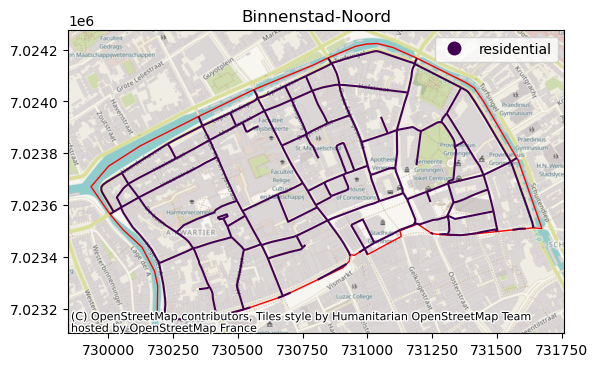

In [21]:
# Show the roads identification for an example neighborhood.

# Define the road groups
road_groups = {
    'KMH_12': 'residential',
    'KMH_15': 'residential',
    'KMH_30': 'residential',
    'KMH_50': 'residential',
    'KMH_60': 'rural',
    'KMH_70': 'rural',
    'KMH_80': 'rural',
    'KMH_90': 'highways',
    'KMH_100': 'highways',
    'KMH_120': 'highways',
    'KMH_130': 'highways',
    'HST_NOA': 'active',
    'HST_NVT': 'active'
}

# Select a neighborhood index
idx = 0  # replace with the index of the neighborhood you want to plot

# Get the buurtcode of the neighborhood
neighborhoodname = geopackage_input_2021.loc[idx, 'neighborhoodname']

# Convert the CRS to Web Mercator
geopackage_input_2021 = geopackage_input_2021.to_crs(epsg=3857)
neighborhood_roads[idx] = neighborhood_roads[idx].to_crs(epsg=3857)

# Create the 'group' column in neighborhood_roads[idx]
neighborhood_roads[idx]['group'] = neighborhood_roads[idx]['MAX_SPEED'].map(road_groups)

# Create the plot
ax = geopackage_input_2021.loc[[idx], 'geometry'].plot(color='none', edgecolor='red')
neighborhood_roads[idx].plot(ax=ax, column='group', cmap='viridis', legend=True)

# Add the basemap
ctx.add_basemap(ax)

# Set the title of the plot to the buurtcode of the neighborhood
plt.title(neighborhoodname)

plt.show()

In [22]:
# As a last task, save the geodataframe as geopackage. 
# Delete the unwanted columns
roads_finished = geopackage_input_2021.drop(columns=['bounding_box', 'KMH_60', 'KMH_30', 'KMH_80', 'KMH_50', 'KMH_70', 'HST_NOA', 'KMH_15', 'KMH_12', 'HST_NVT', 'KMH_120', 'KMH_100', 'KMH_130', 'KMH_90'])
display(roads_finished.head(5))

# Save the GeoDataFrame as a GeoPackage
roads_finished.to_file("C:/Users/20182306/OneDrive - TU Eindhoven/Documents/We-Boost/Repositories/Mobility-Index/output/6_MIWM_roads_2021.gpkg", driver="GPKG")

,neighborhoodcode,neighborhoodname,populationdensityperkm2,percentage0to15years,percentage15to25years,percentage25to45years,percentage45to65years,percentage65yearsorolder,percentageonepersonhouseholds,percentagehouseholdswithoutchildren,percentagehouseholdswithchildren,percentagewesternmigrationbackground,percentagenonwesternmigrationbackground,percentagemen,Distancetolargesupermarket,Distancetodailylifeprovisions,DistanceToPrimaryEducation,DistanceToSecundaryEducation,area_greenery,area_water,area_buildings,geometry,road_length_residential,road_length_rural,road_length_highway,road_length_active
0,BU00140000,Binnenstad-Noord,12192.0,2.0,47.0,35.0,11.0,6.0,82.0,16.0,3.0,19.0,10.0,52.8,0.3,0.1,0.3,0.7,6624.409779,19841.853490,159146.424148,"MULTIPOLYGON (((731098.859 7024208.487, 731191...",9728.001538,0.0,0.0,0.000000
1,BU00140001,Binnenstad-Zuid,11651.0,2.0,46.0,34.0,11.0,7.0,81.0,16.0,3.0,18.0,12.0,53.1,0.2,0.1,0.7,0.9,22284.753602,38974.572262,242741.490433,"MULTIPOLYGON (((731250.044 7023489.510, 731315...",16299.184957,0.0,0.0,0.000000
2,BU00140002,Binnenstad-Oost,15441.0,3.0,42.0,35.0,11.0,9.0,79.0,17.0,4.0,18.0,14.0,52.5,0.5,0.2,0.7,0.4,8335.684283,23497.237602,102269.319342,"MULTIPOLYGON (((731373.773 7024448.518, 731833...",7246.902808,0.0,0.0,704.777948
3,BU00140003,Binnenstad-West,17200.0,2.0,38.0,41.0,10.0,10.0,80.0,17.0,3.0,20.0,10.0,54.7,0.3,0.2,0.9,1.1,0.000000,10530.689805,49307.342094,"MULTIPOLYGON (((730006.692 7023564.747, 730056...",2793.258390,0.0,0.0,30.530014
4,BU00140005,Hortusbuurt-Ebbingekwartier,13019.0,5.0,37.0,33.0,15.0,10.0,78.0,16.0,6.0,19.0,11.0,50.1,0.3,0.2,0.6,0.8,20667.446628,15105.460496,152145.885472,"MULTIPOLYGON (((731549.467 7025025.637, 731094...",10258.251026,0.0,0.0,0.000000
